In [28]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langchain_tavily import TavilySearch

In [180]:
!pip install loguru -qqq

In [181]:
from loguru import logger

# Mocks

In [61]:
MOCKED_SEARCH_RESULT = {'query': 'Preciso encontrar o portal de transparência oficial da prefeitura da cidade Resende-RJ.',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Portal Oficial da Transparência',
   'url': 'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm',
   'content': 'Portal Oficial da Transparência. Prefeitura Municipal de Resende-RJ. Prefeitura Municipal de Resende-RJ. Diário Oficial Eletrônico ... Painel de Transparência; Leis e Decretos (0) Outros Atos Oficiais (0) Licitações e Contratações Diretas (0)',
   'score': 0.86954874,
   'raw_content': None},
  {'title': 'Portal Oficial da Transparência',
   'url': 'https://rj.portaldatransparencia.com.br/prefeitura/resende/?pagina=informacoes',
   'content': 'Portal Oficial da Transparência. Prefeitura Municipal de Resende-RJ. Prefeitura Municipal de ... recursos recebidos, recursos repassados e os instrumentos de transparência da gestão fiscal, que, conforme o art. 48 da Lei Complementar nº 101/00, são: os planos, orçamentos e leis de diretrizes orçamentárias; as prestações de contas e o',
   'score': 0.8443195,
   'raw_content': None},
  {'title': 'Bem vindo ao Portal da Transparência - transparencia.resenprevi.rj.gov.br',
   'url': 'https://transparencia.resenprevi.rj.gov.br/acessoainformacao',
   'content': 'RESENPREVI Transparência Ouvidoria/e-Sic Pesquisa Transparência Ouvidoria Pesquisa TRANSPARÊNCIA OUVIDORIA Uma ferramenta para garantir o atendimento à população com a transparência na gestão pública e atender às determinações da Lei de Acesso à Informação nº 12.527 e a Lei complementar Nº 101. ###### E-SIC ###### OUVIDORIA Lei Nº 12.527 (Acesso a Informação) - Lei Complementar Nº 131 (Transparência) Atos, publicações, pessoal, compras e convênios ###### PESSOAL ###### PUBLICAÇÕES ###### CONVÊNIOS LRF - Lei de Responsabilidade Fiscal e Contas públicas Lei complementar Nº 101 (Transparência) ###### PRESTAÇÃO DE CONTAS DE GESTÃO E GOVERNO ###### DADOS INSTITUCIONAIS ###### DADOS ABERTOS ###### CONTATOS ###### RELATÓRIOS DE GESTÃO/ATIVIDADES ###### PLANOS MUNICIPAIS Radar Nacional da Transparência Pública ###### PLANOS DE SAÚDE ###### PLANOS DE EDUCAÇÃO contato@resenprevi.rj.gov.br',
   'score': 0.7797419,
   'raw_content': None},
  {'title': 'Portal da Transparência - Prefeitura de Resende - Resende, Rio de Janeiro',
   'url': 'https://resende.rj.gov.br/blogtransparencia/page/index.asp',
   'content': 'SIC Conselhos Municipais Legislação de Transparência Concessões Relatórios Certidão TCE/RJ Orgãos da Prefeitura Balanços Contábeis Consolidados Radar da Transparência Diárias e Passagens Lei Aldir BlancDecreto 14.541 de 11/11/2021 da Proteção da Politica de Dados AbertosLegislaçãoLegislação de TransparênciaConsultas de decretos, leis e portariasRelatório de Avaliação Interna sobre a Transparência MunicipalEstatísticas de Pedidos de informaçãoDecreto Municipal Nº 14.729 de 15/02/2022 - Responsabilização Administrativa de PJ pela Prática de Atos Contra a Administração PúblicaAudiência Pública - Transporte Coletivo O SIC (Serviço de Informações ao Cidadão) permite que qualquer pessoa encaminhe pedidos de informação aos órgãos e entidades do Poder Executivo Municipal. Superintendência de Eventos Superintendência de Licitações e Contratos Superintendência de Saúde Superintendência de Transporte e Trânsito Superintendência Municipal de Tecnologia da informação',
   'score': 0.7458619,
   'raw_content': None},
  {'title': 'Home - Prefeitura de Resende',
   'url': 'https://resende.rj.gov.br/',
   'content': 'Resende Conheça Resende JUDOCAS DE 11 E 13 ANOS DE RESENDE CONQUISTAM PÓDIO EM CAMPEONATO REGIONAL NA BAHIA HOSPITAL VETERINÁRIO PÚBLICO DE RESENDE IMPLEMENTA NOVA ETAPA NO ATENDIMENTO AOS ANIMAIS PROGRAMA SAÚDE NA ESCOLA DE RESENDE LEVA ORIENTAÇÕES AOS ALUNOS DA REDE PÚBLICA Guias de Iss Guias de IPTU Ouvidoria da Saúde - Denúncias, Reclamações, Sugestões e Informações Ouvidoria da Saúde - Acompanhe sua manifestação Informações e Serviços ISS E NOTA FISCAL ELETRÔNICA JUDOCAS DE 11 E 13 ANOS DE RESENDE CONQUISTAM PÓDIO EM CAMPEONATO REGIONAL NA BAHIA HOSPITAL VETERINÁRIO PÚBLICO DE RESENDE IMPLEMENTA NOVA ETAPA NO ATENDIMENTO AOS ANIMAIS PROGRAMA SAÚDE NA ESCOLA DE RESENDE LEVA ORIENTAÇÕES AOS ALUNOS DA REDE PÚBLICA CONHEÇA RESENDE',
   'score': 0.40288594,
   'raw_content': None}],
 'response_time': 1.67}

# Funções

In [134]:
from bs4 import BeautifulSoup, Tag, NavigableString, Comment

def clean_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    def clean_node(node):
        if isinstance(node, Comment):
            return None  # Remove comentários
        if isinstance(node, NavigableString):
            return node if node.strip() else None
        if isinstance(node, Tag):
            if node.name in ("script", "style", "noscript", "iframe", "source", "img", "link", "meta"):
                return None

            # Cria uma nova tag com os mesmos atributos, mas de forma correta
            cleaned_tag = soup.new_tag(node.name)
            for attr, value in node.attrs.items():
                cleaned_tag[attr] = value  # Define os atributos da tag

            for child in node.children:
                cleaned_child = clean_node(child)
                if cleaned_child:
                    cleaned_tag.append(cleaned_child)

            return cleaned_tag
        return None

    root = soup.find("html") or soup
    cleaned = clean_node(root)
    return cleaned.prettify()

In [221]:
import asyncio
import base64
from io import BytesIO
from typing import Any
from PIL import Image
from playwright.async_api import async_playwright

async def capture_screenshot(url: str, wait: int = 2, quality: int = 40, timeout: int = 90) -> dict[str, Any]:
    logger.info(f"Capturing screenshot from '{url}'")
    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            context = await browser.new_context()
            page = await context.new_page()
            await page.goto(url, timeout=1000 * timeout)
            await asyncio.sleep(wait)  # Esperar página carregar
            
            screenshot = await page.screenshot(type="jpeg", quality=quality, full_page=True)

            # Converter screenshot para base64
            buffer = BytesIO(screenshot)
            image = Image.open(buffer)

            # Salvar HTML da página
            html_content = await page.content()

            await browser.close()

            # Converter imagem para base64
            buffered = BytesIO()
            image.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            return {
                "url": url,
                "screenshot": img_str,
                "html": clean_html(html_content)
            }

    except Exception as e:
        logger.error(f"Error on capturing screenshot from '{url}'. {e}")
        return {"url": url, "error": str(e)}


# Agente

In [203]:
from typing import Any
from pydantic import BaseModel

class SubDomain(BaseModel):
    base_url: str
    href: str

class AgentState(BaseModel):
    city: str | None = None
    uf: str | None = None
    search_domain_query: str | None = None
    search_domain_failed_queries: list[str] = []
    search_domain_results: dict[str, Any] | None = None
    search_domain_n_results: int = 5
    relevant_subdomains: list[SubDomain] = []

In [209]:
workflow_builder = StateGraph(AgentState)

mock_results = True


def propose_domain_search_query(state: AgentState) -> AgentState:
    query = f"Preciso encontrar o portal de transparência oficial da prefeitura da cidade {state.city}-{state.uf}."
    logger.info(f"[propose_domain_search_query] Proposing the following query to search domains: '{query}'")
    return {"search_domain_query": query}

def search_transparence_domain_candidates(state: AgentState) -> AgentState:
    if mock_results:
        logger.info(f"[search_transparence_domain_candidates] Returning mocked result")
        return {"search_domain_results": MOCKED_SEARCH_RESULT}

    logger.info(f"[search_transparence_domain_candidates] Search '{state.search_domain_query}' with Tavily")
    tavily_search = TavilySearch(k=state.search_domain_n_results)
    if state.search_domain_query:
        results = tavily_search.invoke(state.search_domain_query)
        return {"search_domain_results": results}
    raise ValueError("Web search query not defined.")


workflow_builder.add_node("propose_domain_search_query", propose_domain_search_query)
workflow_builder.add_node("search_transparence_domain_candidates", search_transparence_domain_candidates)


workflow_builder.add_edge(START, "propose_domain_search_query")
workflow_builder.add_edge("propose_domain_search_query", "search_transparence_domain_candidates")
workflow_builder.add_edge("search_transparence_domain_candidates", END)

workflow = workflow_builder.compile()

In [210]:
init_state = {"city": "Resende", "uf": "RJ"}

state = workflow.invoke(init_state)
state = AgentState(**state)

2025-04-24 03:44:05.613 | INFO     | __main__:propose_domain_search_query:8 - [propose_domain_search_query] Proposing the following query to search domains: 'Preciso encontrar o portal de transparência oficial da prefeitura da cidade Resende-RJ.'
2025-04-24 03:44:05.615 | INFO     | __main__:search_transparence_domain_candidates:13 - [search_transparence_domain_candidates] Returning mocked result


In [211]:
import asyncio
from textwrap import dedent
from IPython.display import Image as IPythonImage, display

logger.info(f"[search_relevant_subdomains] Looking for relevant subdomains")
responses = {}

for url in [x["url"] for x in state.search_domain_results["results"]]:
    logger.info(f"[search_relevant_subdomains] verifying subdomains in '{url}'")
    result = await capture_screenshot(url, quality=20)
    
    if not "error" in result:
        base64_image = result["screenshot"]
        
        PROMPT = dedent(f"""
        # SUA TAREFA
        
        Analise a imagem da página web e seu código html.
        Verifique se nessa página tem alguma tabela ou organização e dados
        que lista nome e salário de funcionários públicos. Se não, retorne os links para outras páginas
        que sejam mais prováveis de se encontrar uma tabela com os dados de salários
        dos servidores públicos da cidade de {state.city}-{state.uf}. Caso voce considere
        que nessa página nao tem nenhum link para uma tabela com salários, 
        apenas retorne has_link_to_salary = False e mantenha a lista relevant_links vazia.
        
        # Código html da página
        ```html
        {result["html"]}
        ```
        """)
        
        class PublicServantsSalaryDomainSearchResults(BaseModel):
            has_link_to_salary: bool
            has_salary_table: bool
            relevant_links: list[str] | None
        
        
        response = client.responses.parse(
            model="gpt-4.1-mini",
            input=[
                {
                    "role": "system",
                    "content": (
                        "Você é um usuário humano que está procurando encontrar uma tabela "
                        f"com o salário dos servidores públicos da cidade de {state.city}-{state.uf}." 
                    )
                },
                
                {
                    "role": "user",
                    "content": [
                        { "type": "input_text", "text": PROMPT
                        },
                        {
                            "type": "input_image",
                            "image_url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    ],
                }
            ],
            text_format = PublicServantsSalaryDomainSearchResults,
        ).output_parsed

        responses[url] = response

        if response.has_link_to_salary:
            subdomains = [SubDomain(base_url=url, href=href) for href in response.relevant_links] 
            state.relevant_subdomains = state.relevant_subdomains + subdomains
        else:
            logger.info(f"[search_relevant_subdomains] The url '{url}' has no relevant links.")
    
    else:
        logger.error(f"[search_relevant_subdomains] The url '{url}' is not accessible.")
        response = None

2025-04-24 03:44:07.144 | INFO     | __main__:<module>:5 - [search_relevant_subdomains] Looking for relevant subdomains
2025-04-24 03:44:07.148 | INFO     | __main__:<module>:9 - [search_relevant_subdomains] verifying subdomains in 'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm'
2025-04-24 03:44:07.149 | INFO     | __main__:capture_screenshot:9 - Capturing screenshot from 'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm'
2025-04-24 03:44:14.495 | INFO     | __main__:<module>:70 - [search_relevant_subdomains] The url 'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm' has no relevant links.
2025-04-24 03:44:14.496 | INFO     | __main__:<module>:9 - [search_relevant_subdomains] verifying subdomains in 'https://rj.portaldatransparencia.com.br/prefeitura/resende/?pagina=informacoes'
2025-04-24 03:44:14.496 | INFO     | __main__:capture_screenshot:9 - Capturing screenshot from 'https://rj.portaldatransparencia.com.br/pr

In [213]:
state.relevant_subdomains

[SubDomain(base_url='https://transparencia.resenprevi.rj.gov.br/acessoainformacao', href='folhadepagamento.php'),
 SubDomain(base_url='https://resende.rj.gov.br/blogtransparencia/page/index.asp', href='https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA==')]

In [216]:
responses

{'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm': PublicServantsSalaryDomainSearchResults(has_link_to_salary=False, has_salary_table=False, relevant_links=[]),
 'https://transparencia.resenprevi.rj.gov.br/acessoainformacao': PublicServantsSalaryDomainSearchResults(has_link_to_salary=True, has_salary_table=False, relevant_links=['folhadepagamento.php']),
 'https://resende.rj.gov.br/blogtransparencia/page/index.asp': PublicServantsSalaryDomainSearchResults(has_link_to_salary=True, has_salary_table=False, relevant_links=['https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA=='])}

In [222]:
url = "https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA=="

logger.info(f"[search_relevant_subdomains] verifying subdomains in '{url}'")
result = await capture_screenshot(url, quality=20, wait=5)

if not "error" in result:
    base64_image = result["screenshot"]
    
    PROMPT = dedent(f"""
    # SUA TAREFA
    
    Analise a imagem da página web e seu código html.
    Verifique se nessa página tem alguma tabela ou organização e dados
    que lista nome e salário de funcionários públicos. Se não, retorne os links para outras páginas
    que sejam mais prováveis de se encontrar uma tabela com os dados de salários
    dos servidores públicos da cidade de {state.city}-{state.uf}. Caso voce considere
    que nessa página nao tem nenhum link para uma tabela com salários, 
    apenas retorne has_link_to_salary = False e mantenha a lista relevant_links vazia.
    
    # Código html da página
    ```html
    {result["html"]}
    ```
    """)
    
    class PublicServantsSalaryDomainSearchResults(BaseModel):
        has_link_to_salary: bool
        has_salary_table: bool
        relevant_links: list[str] | None
    
    
    response = client.responses.parse(
        model="gpt-4.1-mini",
        input=[
            {
                "role": "system",
                "content": (
                    "Você é um usuário humano que está procurando encontrar uma tabela "
                    f"com o salário dos servidores públicos da cidade de {state.city}-{state.uf}." 
                )
            },
            
            {
                "role": "user",
                "content": [
                    { "type": "input_text", "text": PROMPT
                    },
                    {
                        "type": "input_image",
                        "image_url": f"data:image/jpeg;base64,{base64_image}",
                    },
                ],
            }
        ],
        text_format = PublicServantsSalaryDomainSearchResults,
    ).output_parsed

2025-04-24 03:53:01.448 | INFO     | __main__:<module>:3 - [search_relevant_subdomains] verifying subdomains in 'https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA=='
2025-04-24 03:53:01.450 | INFO     | __main__:capture_screenshot:9 - Capturing screenshot from 'https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA=='


In [223]:
response

PublicServantsSalaryDomainSearchResults(has_link_to_salary=True, has_salary_table=True, relevant_links=None)

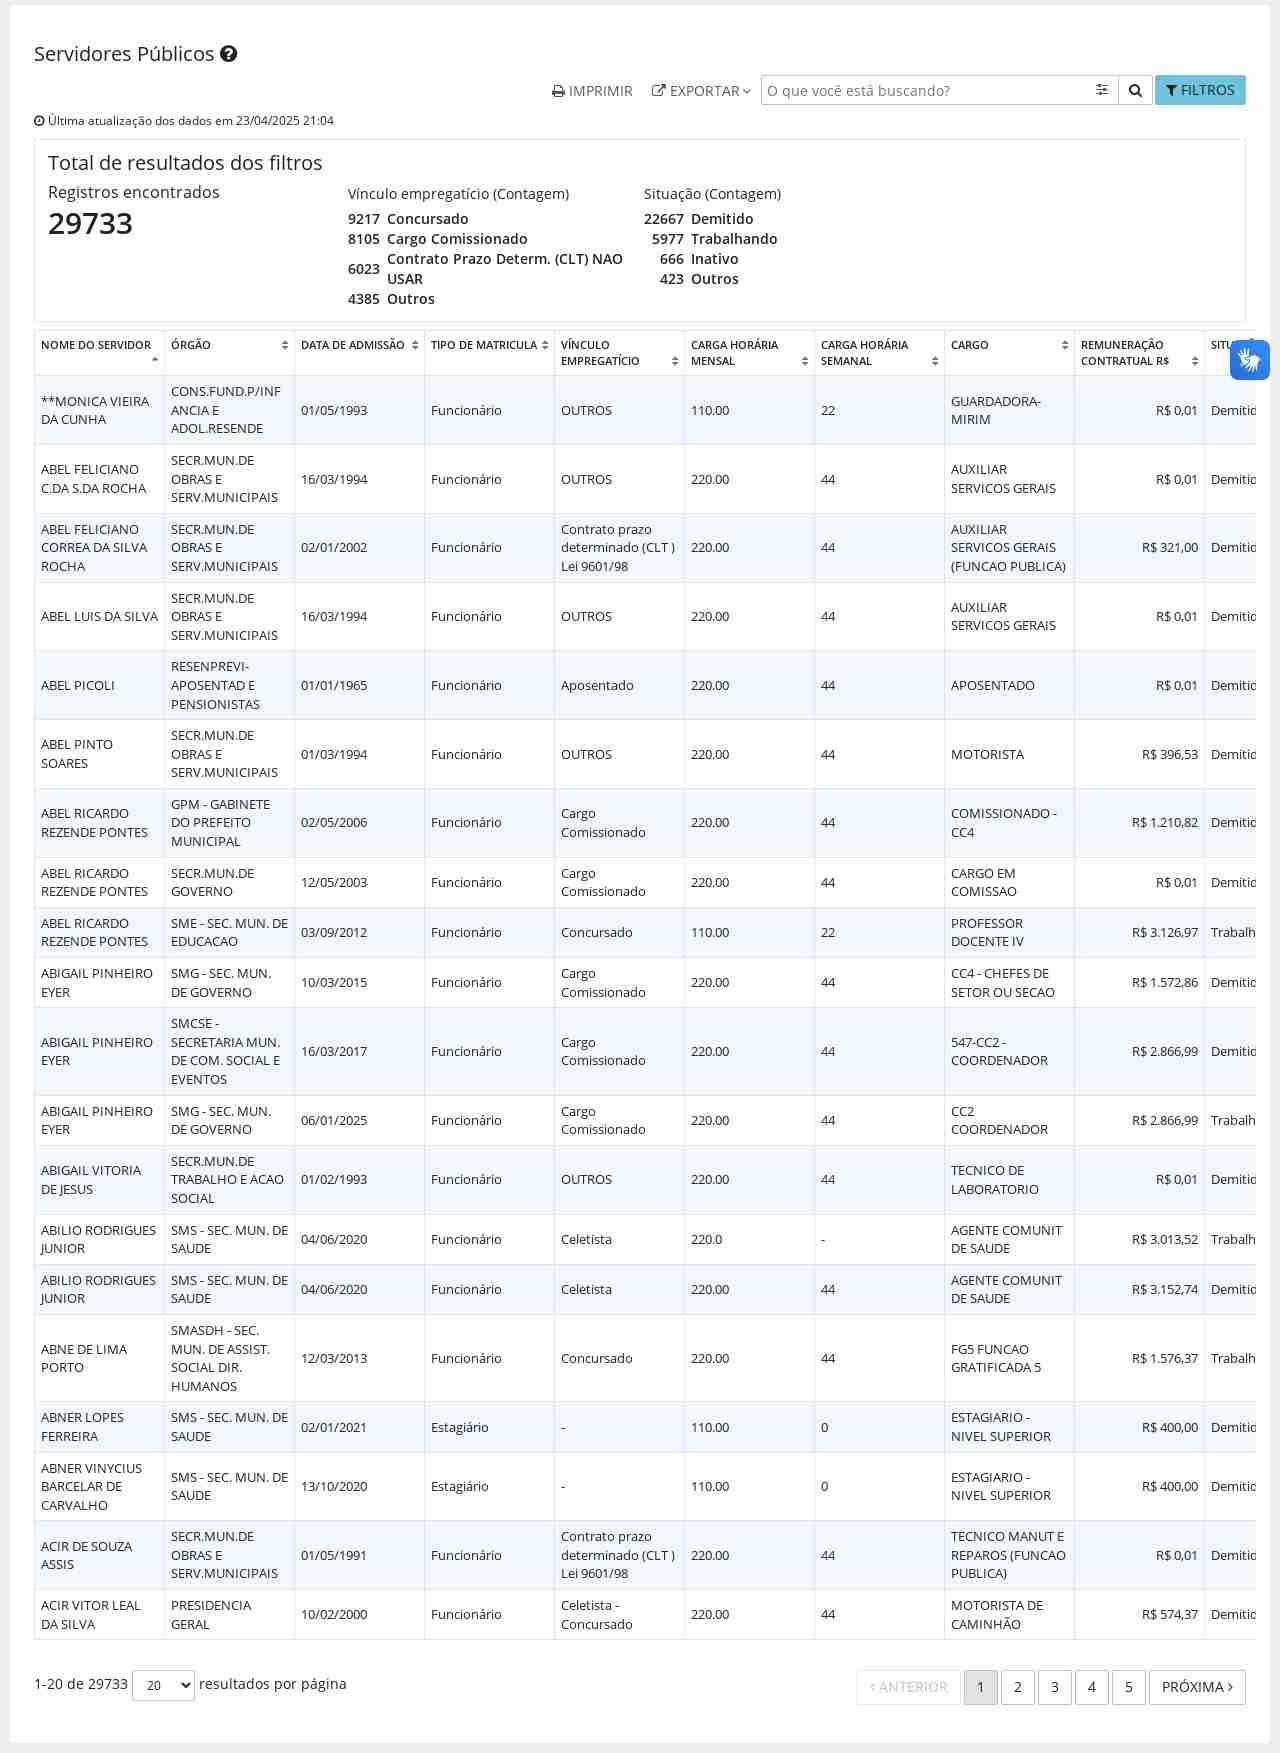

In [224]:
if "screenshot" in result:
    display(IPythonImage(data=base64.b64decode(result["screenshot"])))

In [193]:
state.relevant_subdomains

['folhadepagamento.php',
 'https://transparencia.betha.cloud/#/mLjqO7Hq0-hN_1MV2wA28A==/incorporacao/MTY3MA==',
 '/blogtransparencia/page/quadrodepessoasetabela.asp']

# Teste

In [194]:
workflow_builder = StateGraph(AgentState)

mock_results = False


def propose_domain_search_query(state: AgentState) -> AgentState:
    query = f"Preciso encontrar o portal de transparência oficial da prefeitura da cidade {state.city}-{state.uf}."
    logger.info(f"[propose_domain_search_query] Proposing the following query to search domains: '{query}'")
    return {"search_domain_query": query}

def search_transparence_domain_candidates(state: AgentState) -> AgentState:
    if mock_results:
        logger.info(f"[search_transparence_domain_candidates] Returning mocked result")
        return {"search_domain_results": MOCKED_SEARCH_RESULT}

    logger.info(f"[search_transparence_domain_candidates] Search '{state.search_domain_query}' with Tavily")
    tavily_search = TavilySearch(k=state.search_domain_n_results)
    if state.search_domain_query:
        results = tavily_search.invoke(state.search_domain_query)
        return {"search_domain_results": results}
    raise ValueError("Web search query not defined.")


workflow_builder.add_node("propose_domain_search_query", propose_domain_search_query)
workflow_builder.add_node("search_transparence_domain_candidates", search_transparence_domain_candidates)


workflow_builder.add_edge(START, "propose_domain_search_query")
workflow_builder.add_edge("propose_domain_search_query", "search_transparence_domain_candidates")
workflow_builder.add_edge("search_transparence_domain_candidates", END)

workflow = workflow_builder.compile()

In [198]:
init_state = {"city": "Poços de Caldas", "uf": "MG"}

state = workflow.invoke(init_state)
state = AgentState(**state)

2025-04-24 02:54:29.250 | INFO     | __main__:propose_domain_search_query:8 - [propose_domain_search_query] Proposing the following query to search domains: 'Preciso encontrar o portal de transparência oficial da prefeitura da cidade Poços de Caldas-MG.'
2025-04-24 02:54:29.251 | INFO     | __main__:search_transparence_domain_candidates:16 - [search_transparence_domain_candidates] Search 'Preciso encontrar o portal de transparência oficial da prefeitura da cidade Poços de Caldas-MG.' with Tavily


In [199]:
import asyncio
from IPython.display import Image as IPythonImage, display

logger.info(f"[search_relevant_subdomains] Looking for relevant subdomains")

for url in [x["url"] for x in state.search_domain_results["results"]]:
    logger.info(f"[search_relevant_subdomains] verifying subdomains in '{url}'")
    result = await capture_screenshot(url, quality=20)
    
    if not "error" in result:
        base64_image = result["screenshot"]
        
        PROMPT = f"""
        # SUA TAREFA
        
        Analise a imagem da página web e seu código html e retorne os links
        mais prováveis de se encontrar uma tabela com os dados de salários
        dos servidores públicos da cidade de {state.city}-{state.uf}. Caso voce considere
        que nessa página nao tem nenhum link para uma tabela com salários, 
        apenas retorne has_link_to_salary = Falsem e mantenha a lista relevant_links vazia
        
        # Código html da página
        ```html
        {result["html"]}
        ```
        """
        
        class PublicServantsSalaryDomainSearchResults(BaseModel):
            has_link_to_salary: bool
            relevant_links: list[str] | None
        
        
        response = client.responses.parse(
            model="gpt-4.1",
            input=[
                {
                    "role": "system",
                    "content": (
                        "Você é um usuário humano que está procurando encontrar uma tabela "
                        f"com o salário dos servidores públicos da cidade de {state.city}-{state.uf}." 
                    )
                },
                
                {
                    "role": "user",
                    "content": [
                        { "type": "input_text", "text": PROMPT
                        },
                        {
                            "type": "input_image",
                            "image_url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    ],
                }
            ],
            text_format = PublicServantsSalaryDomainSearchResults,
        ).output_parsed

        if response.has_link_to_salary:
            state.relevant_subdomains = state.relevant_subdomains + response.relevant_links
        else:
            logger.info(f"[search_relevant_subdomains] The url '{url}' has no relevant links.")
    
    else:
        logger.error(f"[search_relevant_subdomains] The url '{url}' is not accessible.")
        response = None

2025-04-24 02:54:32.178 | INFO     | __main__:<module>:4 - [search_relevant_subdomains] Looking for relevant subdomains
2025-04-24 02:54:32.180 | INFO     | __main__:<module>:7 - [search_relevant_subdomains] verifying subdomains in 'http://mg.portaldatransparencia.com.br/prefeitura/pocosdecaldas/index.cfm?pagina=informacoes'
2025-04-24 02:54:32.181 | INFO     | __main__:capture_screenshot:9 - Capturing screenshot from 'http://mg.portaldatransparencia.com.br/prefeitura/pocosdecaldas/index.cfm?pagina=informacoes'
2025-04-24 02:54:42.712 | INFO     | __main__:<module>:62 - [search_relevant_subdomains] The url 'http://mg.portaldatransparencia.com.br/prefeitura/pocosdecaldas/index.cfm?pagina=informacoes' has no relevant links.
2025-04-24 02:54:42.713 | INFO     | __main__:<module>:7 - [search_relevant_subdomains] verifying subdomains in 'https://www.pocosdecaldas.mg.leg.br/transparencia/'
2025-04-24 02:54:42.713 | INFO     | __main__:capture_screenshot:9 - Capturing screenshot from 'https:/

In [200]:
state.relevant_subdomains

['https://www.pocosdecaldas.mg.leg.br/transparencia/recursos-humanos',
 'http://187.49.207.14:8081/portalcidadao/#78c3e513dd43cb27d8a3e2f376196ffc656d7ea577b2c6fb52df1a2bfe4be3603613f9dbb7a842e0479411a661647518503c0b2236d23b5ea3a7c340749acd7e717d68915651140ccb3bc350830382440f8cfb63646d3b7e946f820a8b1c09cc9066102c3d0a9798b8fad0ef2b9fc8d12ecb4413b1bd002d27d23bbcbbb1fc246bab75fe744635c24c74f2bd4086f8d9a611d3b101dab56dbd0c46017b1b87755507c51599956648e1d547dbd353a30166acf60e7bf77193a83bb96becd5313b82a55849ef73b1b21a1e61ea7314117aaa905268b2bda0542c2fae34ee2b3e053024839323d7625ebc2e81f705a15999bc0233bfd501e7114d59fe42f9fc5e39cc8542dbe0c0b410ac405b93708724a08760e657d90ca5f2',
 'http://187.49.207.14:8081/GRP/',
 'http://187.49.207.14:8081/portalcidadao/#78c3e513dd43cb27d8a3e2f376196ffc656d7ea577b2c6fbee3c95c55e2d69139d14f915aa%C4%B2d70a7c3a38b73c7c2f606a8a69701a6dd2a0cca3f76489a65e30ab5534bfec39a3a0a48eaf20c54208cf0aa04562d365c788f9125e23797fd9bd18b76039899b6fee9de5c7e5e24fb14e72a803f185bf498a4

In [161]:
response.output_parsed

AttributeError: 'NoneType' object has no attribute 'output_parsed'

In [158]:
if "screenshot" in result:
    display(IPythonImage(data=base64.b64decode(result["screenshot"])))

In [141]:

# url = 'https://www.espn.com.br/'

# async with async_playwright() as p:
#     browser = await p.chromium.launch()
#     context = await browser.new_context()
#     page = await context.new_page()
#     await page.goto(url, timeout=90000)
#     await asyncio.sleep(2)  # Esperar página carregar
    
#     screenshot = await page.screenshot(type="jpeg", quality=20, full_page=True)

#     # Converter screenshot para base64
#     buffer = BytesIO(screenshot)
#     image = Image.open(buffer)

#     # Salvar HTML da página
#     html_content = await page.content()

#     await browser.close()

#     # Converter imagem para base64
#     buffered = BytesIO()
#     image.save(buffered, format="JPEG")
#     img_str = base64.b64encode(buffered.getvalue()).decode()

#     result = {
#         "url": url,
#         "screenshot": img_str,
#         "html": html_content
#     }

In [132]:
# result

In [139]:
# clean_html(result["html"])

In [119]:
result

{'url': 'https://resende.rj.gov.br/blogtransparencia/page/index.asp',
 'error': 'Page.goto: Timeout 30000ms exceeded.\nCall log:\nnavigating to "https://resende.rj.gov.br/blogtransparencia/page/index.asp", waiting until "load"\n'}

In [82]:
result.keys()

dict_keys(['url', 'screenshot', 'html'])

In [89]:
from openai import OpenAI


base64_image = result["screenshot"]

client = OpenAI()

response = client.responses.create(
    model="gpt-4.1",
    input=[
        {
            "role": "user",
            "content": [
                { "type": "input_text", "text": "what's in this image?" },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            ],
        }
    ],
)

In [ ]:
from openai import OpenAI
from pydantic import BaseModel


base64_image = result["screenshot"]

client = OpenAI()

# class CalendarEvent(BaseModel):
#     name: str
#     date: str
#     participants: list[str]

# response = client.responses.parse(
#     model="gpt-4o-2024-08-06",
#     input=[
#         {"role": "system", "content": "Extract the event information."},
#         {
#             "role": "user",
#             "content": "Alice and Bob are going to a science fair on Friday.",
#         },
#     ],
#     text_format=CalendarEvent,
# )

# event = response.output_parsed

In [97]:

base64_image = result["screenshot"]

class ImageAnalysisResponse(BaseModel):
    has_link_to_salary: str


response = client.responses.parse(
    model="gpt-4.1",
    input=[
        {
            "role": "user",
            "content": [
                { "type": "input_text", "text": "Nessa página, tem algum elemento html que me leva a alguma página onde consigo acessar informações de salário de servidores públicos?" },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            ],
        }
    ],
    text_format = ImageAnalysisResponse,
)

In [98]:
response.output_parsed

ImageAnalysisResponse(has_link_to_salary="Sim, há um elemento com o texto 'Quadro de Pessoal e Remuneração', que normalmente leva a uma página com informações sobre salários de servidores.")

In [99]:
# print(response.output[0].content[0].text)

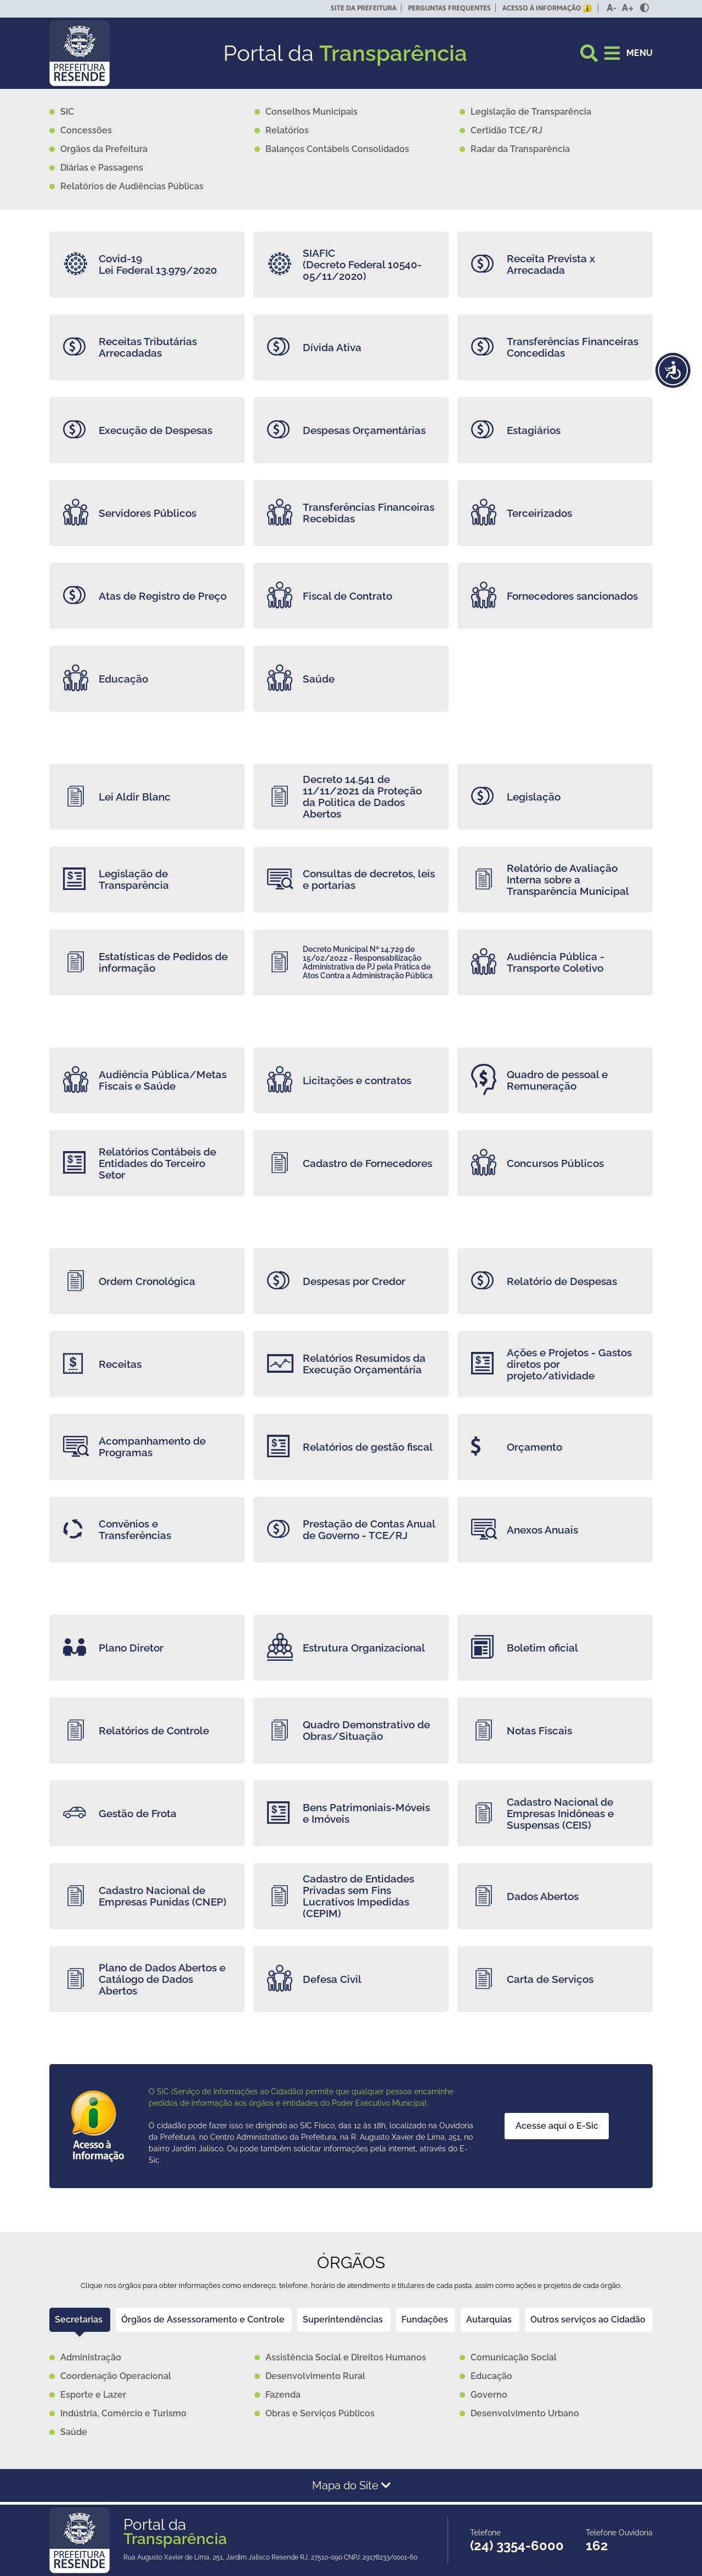

In [79]:
if "screenshot" in result:
    display(IPythonImage(data=base64.b64decode(result["screenshot"])))

In [60]:
results["search_domain_results"]

{'query': 'Preciso encontrar o portal de transparência oficial da prefeitura da cidade Resende-RJ.',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Portal Oficial da Transparência',
   'url': 'http://www.rj.portaldatransparencia.com.br/prefeitura/resende/index.cfm',
   'content': 'Portal Oficial da Transparência. Prefeitura Municipal de Resende-RJ. Prefeitura Municipal de Resende-RJ. Diário Oficial Eletrônico ... Painel de Transparência; Leis e Decretos (0) Outros Atos Oficiais (0) Licitações e Contratações Diretas (0)',
   'score': 0.86954874,
   'raw_content': None},
  {'title': 'Portal Oficial da Transparência',
   'url': 'https://rj.portaldatransparencia.com.br/prefeitura/resende/?pagina=informacoes',
   'content': 'Portal Oficial da Transparência. Prefeitura Municipal de Resende-RJ. Prefeitura Municipal de ... recursos recebidos, recursos repassados e os instrumentos de transparência da gestão fiscal, que, conforme o art. 48 da Lei Complement